In [46]:
# Imports and Constants
import numpy as np
from scipy.special import comb
from scipy.optimize import minimize, LinearConstraint, Bounds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Orbital parameters (from Project_Spec.md)
ISS_ALTITUDE_KM = 423  # ISS orbit altitude in km AMSL
CHASER_ALTITUDE_KM = 300  # Chaser altitude in km AMSL
KOZ_ALTITUDE_KM = 100  # Keep Out Zone altitude in km AMSL

EARTH_RADIUS_KM = 6371.0  # Earth radius in km
KOZ_RADIUS = EARTH_RADIUS_KM + KOZ_ALTITUDE_KM  # KOZ radius from Earth center
ISS_RADIUS = EARTH_RADIUS_KM + ISS_ALTITUDE_KM
CHASER_RADIUS = EARTH_RADIUS_KM + CHASER_ALTITUDE_KM

# Gravitational parameters
EARTH_MU = 3.986004418e14  # m³/s²

# Scaling: use km as base unit
SCALE_FACTOR = 1e3  # 1 unit = 1 km
EARTH_MU_SCALED = EARTH_MU / (SCALE_FACTOR**3)  # Scaled for km


In [47]:
def get_D_matrix(N):
    """
    Compute derivative matrix D for Bézier curve of degree N.
    
    From Project_Spec.md:
    [D]_i,j = N × { -1 if j=i, 1 if j=i+1, 0 otherwise }
    
    Args:
        N: Degree of Bézier curve
    
    Returns:
        D: (N, N+1) matrix
    """
    D = np.zeros((N, N+1))
    for i in range(N):
        D[i, i] = -N
        D[i, i+1] = N
    return D

def get_E_matrix(N):
    """
    Compute elevation matrix E for Bézier curve of degree N.
    Elevates degree from N to N+1.
    
    From Project_Spec.md equation:
    E_{N→N+1} with specific structure
    
    Args:
        N: Original degree
    
    Returns:
        E: (N+2, N+1) matrix
    """
    E = np.zeros((N+2, N+1))
    
    # First row: i=1, j=1 → 1
    E[0, 0] = 1.0
    
    # Last row: i=N+2, j=N+1 → 1
    E[N+1, N] = 1.0
    
    # Middle rows: 2 ≤ i ≤ N+1 (1-indexed) → rows 1 to N (0-indexed)
    for row_idx in range(1, N+1):  # 0-indexed row: 1 to N
        i_1idx = row_idx + 1  # Convert to 1-indexed for formula
        # j = i-1 (1-indexed) → col = row_idx - 1 (0-indexed)
        E[row_idx, row_idx - 1] = (N + 2 - i_1idx) / (N + 1)
        # j = i (1-indexed) → col = row_idx (0-indexed)
        E[row_idx, row_idx] = (i_1idx - 1) / (N + 1)
    
    return E


In [48]:
class BezierCurve:
    """
    Bézier curve implementation using D/E matrices for derivatives.
    """
    
    def __init__(self, control_points):
        P = np.array(control_points, dtype=float)
        if P.ndim != 2: # cus np.array makes control_points a 2D matrix
            raise ValueError("control_points must be (N+1, dim)")
        self.control_points = P
        self.degree = P.shape[0] - 1 # = N
        self.dimension = P.shape[1] # P.shape = (N+1, dim)
        
        # Precompute D and E matrices
        self.D = get_D_matrix(self.degree)
        if self.degree > 0:
            self.E = get_E_matrix(self.degree - 1)  # E elevates from N-1 to N
    
    def point(self, tau):
        """Evaluate curve at parameter tau using Bernstein basis."""
        N, d = self.degree, self.dimension
        out = np.zeros(d)
        for i in range(N + 1):
            b = comb(N, i) * (tau ** i) * ((1 - tau) ** (N - i))
            out += b * self.control_points[i]
        return out
    
    def velocity_control_points(self):
        """
        Compute velocity control points using V = EDP.
        Returns control points for velocity curve (degree N, N+1 control points).
        """
        if self.degree == 0:
            return np.zeros((1, self.dimension))
        
        # V = E @ D @ P
        # P is (N+1, dim), D is (N, N+1), E is (N+1, N)
        # Result: (N+1, dim)
        V_ctrl = self.E @ self.D @ self.control_points
        return V_ctrl
    
    def acceleration_control_points(self):
        """
        Compute acceleration control points using A = EDEDP.
        Returns control points for acceleration curve.
        """
        # Acceleration control points using EDEDP as instructed.
        if self.degree < 2:
            return np.zeros(((self.degree+1), self.dimension))
        # Use EDEDP directly per the analytic/formal instructions.
        A_ctrl = self.E @ self.D @ self.E @ self.D @ self.control_points
        # (Resulting shape: (N+1, d);
        return A_ctrl
    
    def velocity(self, tau):
        """Evaluate velocity at parameter tau."""
        if self.degree == 0:
            return np.zeros(self.dimension)
        V_ctrl = self.velocity_control_points()
        # Velocity curve has degree N (same as original)
        N = self.degree
        out = np.zeros(self.dimension)
        for i in range(N + 1):
            b = comb(N, i) * (tau ** i) * ((1 - tau) ** (N - i))
            out += b * V_ctrl[i]
        return out

    def acceleration(self, tau):
        """Evaluate acceleration at parameter tau."""
        if self.degree < 2:
            return np.zeros(((self.degree+1), self.dimension))
        A_ctrl = self.acceleration_control_points()
        # Acceleration curve has degree N due to the E matrix
        N_accel = self.degree
        out = np.zeros(self.dimension)
        for i in range(N_accel + 1):
            b = comb(N_accel, i) * (tau ** i) * ((1 - tau) ** (N_accel - i))
            out += b * A_ctrl[i]
        return out


In [49]:
def de_casteljau_split_1d(N, tau, basis_index):
    """
    Compute De Casteljau subdivision coefficients for a single basis vector.
    """
    w = np.zeros(N+1)
    w[basis_index] = 1.0
    left = [w[0]]
    right = [w[-1]]
    W = w.copy()
    
    for _ in range(1, N+1):
        W = (1 - tau) * W[:-1] + tau * W[1:]
        left.append(W[0])
        right.append(W[-1])
    
    L = np.array(left)
    R = np.array(right[::-1])
    return L, R

def de_casteljau_split_matrices(N, tau):
    """Compute subdivision matrices S_left and S_right."""
    S_left = np.zeros((N+1, N+1))
    S_right = np.zeros((N+1, N+1))
    
    for j in range(N+1):
        L, R = de_casteljau_split_1d(N, tau, j)
        S_left[:, j] = L
        S_right[:, j] = R
    return S_left, S_right

def segment_matrices_equal_params(N, n_seg):
    """
    Generate segment matrices for equal-parameter splitting.
    Returns list of (N+1, N+1) matrices, one per segment.
    """
    if n_seg < 1:
        raise ValueError("n_seg must be >= 1")
    if n_seg == 1:
        return [np.eye(N+1)]
    
    mats = []
    remainder = np.eye(N+1)
    
    for k in range(n_seg, 1, -1):
        tau = 1.0 / k
        S_L, S_R = de_casteljau_split_matrices(N, tau)
        mats.append(S_L @ remainder)
        remainder = S_R @ remainder
    mats.append(remainder)
    return mats


In [50]:
def build_koz_constraints(A_list, P, r_e, dim=3, c_KOZ=None):
    """
    Build KOZ (Keep Out Zone) linear constraints for all segments.

    For each segment j:
    1. Compute CG (centroid) of control points: Qi = Ai @ P
    2. Generate unit vector nj from KOZ center (c_KOZ) to CG
    3. Create half-space constraint: nj^T @ Qi >= r_e

    Args:
        A_list: List of segment transformation matrices
        P: Control points (N+1, dim)
        r_e: KOZ radius
        dim: Spatial dimension
        c_KOZ: KOZ center, shape (dim,) or None (if None, uses origin and warns)

    Returns:
        LinearConstraint object
    """
    Np1 = A_list[0].shape[1]
    rows, lbs = [], []

    if c_KOZ is None:
        import warnings
        warnings.warn("c_KOZ (KOZ center) not specified; defaulting to origin.")
        c_KOZ = np.zeros(dim)

    for Ai in A_list:
        Qi = Ai @ P  # Control points of segment i
        ci = Qi.mean(axis=0)  # Centroid (CG)

        # Unit vector from KOZ center to CG
        Nj = ci - c_KOZ
        Nj_norm = np.linalg.norm(Nj)
        if Nj_norm < 1e-12:
            # If CG coincides with KOZ center, skip this segment (degenerate case)
            continue

        nj = Nj / Nj_norm  # Unit normal vector
        
        # Create constraint for each control point in segment
        for k in range(Np1):
            row = np.zeros(Np1 * dim)
            for j in range(Np1):
                coeff = Ai[k, j]
                start = j * dim
                row[start:start+dim] += coeff * nj
            rows.append(row)
            lbs.append(r_e)
    
    if len(rows) == 0:
        # No constraints generated
        A_const = np.zeros((1, Np1 * dim))
        lb_const = np.array([-np.inf])
        ub_const = np.array([np.inf])
    else:
        A_const = np.vstack(rows)
        lb_const = np.array(lbs)
        ub_const = np.full_like(lb_const, np.inf)
    
    return LinearConstraint(A_const, lb_const, ub_const)

def build_boundary_constraints(P_init, v0=None, v1=None, a0=None, a1=None, dim=3):
    """
    Build boundary condition equality constraints.
    
    Args:
        P_init: Initial control points (N+1, dim)
        v0: Initial velocity (optional, shape (dim,))
        v1: Final velocity (optional, shape (dim,))
        a0: Initial acceleration (optional, shape (dim,))
        a1: Final acceleration (optional, shape (dim,))
        dim: Spatial dimension
    
    Returns:
        list of LinearConstraint objects
    """
    Np1 = P_init.shape[0]
    N = Np1 - 1
    
    constraints = []
    
    # Position constraints: p(0) = P0, p(1) = PN
    # These are handled via bounds, not equality constraints
    # (we'll set bounds separately)
    
    # Velocity constraints
    if v0 is not None:
        # v(0) = N(P1 - P0)
        # N*P1 - N*P0 = v0
        row = np.zeros(Np1 * dim)
        row[0:dim] = -N  # -N * P0
        row[dim:2*dim] = N  # N * P1
        constraints.append(LinearConstraint(row.reshape(1, -1), v0, v0))
    
    if v1 is not None:
        # v(1) = N(PN - PN-1)
        # N*PN - N*PN-1 = v1
        row = np.zeros(Np1 * dim)
        row[-2*dim:-dim] = -N  # -N * P_{N-1}
        row[-dim:] = N  # N * PN
        constraints.append(LinearConstraint(row.reshape(1, -1), v1, v1))
    
    # Acceleration constraints
    if a0 is not None and N >= 2:
        # a(0) = N(N-1)(P2 - 2P1 + P0)
        row = np.zeros(Np1 * dim)
        row[0:dim] = N*(N-1)  # N(N-1) * P0
        row[dim:2*dim] = -2*N*(N-1)  # -2N(N-1) * P1
        row[2*dim:3*dim] = N*(N-1)  # N(N-1) * P2
        constraints.append(LinearConstraint(row.reshape(1, -1), a0, a0))
    
    if a1 is not None and N >= 2:
        # a(1) = N(N-1)(PN - 2PN-1 + PN-2)
        row = np.zeros(Np1 * dim)
        row[-3*dim:-2*dim] = N*(N-1)  # N(N-1) * P_{N-2}
        row[-2*dim:-dim] = -2*N*(N-1)  # -2N(N-1) * P_{N-1}
        row[-dim:] = N*(N-1)  # N(N-1) * PN
        constraints.append(LinearConstraint(row.reshape(1, -1), a1, a1))
    
    return constraints


In [51]:
def _compute_cost_only(P_flat, Np1, dim, n_samples=50):
    """Helper function to compute cost only (no recursion)."""
    P = P_flat.reshape(Np1, dim)
    curve = BezierCurve(P)
    ts = np.linspace(0, 1, n_samples)
    
    cost = 0.0
    accel = 0.0
    dtau = 1.0 / (n_samples - 1)
    
    for tau in ts:
        # Geometric acceleration at each point on the curve
        a_geom = curve.acceleration(tau)

        # Gravitational acceleration at each point on the curve
        pos = curve.point(tau)
        r = np.linalg.norm(pos)
        
        # Direction toward origin (negative of position unit vector)
        if r > 1e-6:
            a_grav = -EARTH_MU_SCALED / r**2 * (pos / r)
        else:
            a_grav = np.zeros_like(pos)
        
        # Cost: ||a_geom - a_grav||²
        diff = a_geom - a_grav
        norm_diff = np.linalg.norm(diff)
        cost += norm_diff**2 * dtau
        accel += norm_diff * dtau
    
    return cost, accel

def cost_function_gradient_hessian(P_flat, Np1, dim, n_samples=50, compute_grad=True):
    """
    Compute cost function, gradient, and Hessian approximation.
    Returns: (cost, gradient, hessian)
    
    Args:
        compute_grad: If False, only compute cost (for efficiency when gradient not needed)
    """
    cost, _ = _compute_cost_only(P_flat, Np1, dim, n_samples)
    
    if not compute_grad:
        return cost, None, None
    
    # Compute gradient using finite differences
    eps = 1e-6
    grad = np.zeros(Np1 * dim)
    for i in range(Np1 * dim):
        P_pert = P_flat.copy()
        P_pert[i] += eps
        cost_pert, _ = _compute_cost_only(P_pert, Np1, dim, n_samples)
        grad[i] = (cost_pert - cost) / eps
    
    # Simple diagonal Hessian approximation (regularization)
    hess = np.eye(Np1 * dim) * 1e-6
    
    return cost, grad, hess


In [52]:
def optimize_orbital_docking(
    P_init, 
    n_seg=8, 
    r_e=KOZ_RADIUS, 
    max_iter=20,
    tol=1e-6,
    v0=None,
    v1=None,
    a0=None,
    a1=None,
    sample_count=100,
    verbose=True
):
    """
    Optimize Bézier curve for orbital docking.
    
    Args:
        P_init: Initial control points (N+1, dim)
        n_seg: Number of segments for KOZ linearization
        r_e: KOZ radius
        max_iter: Max optimization iterations
        tol: Convergence tolerance
        v0, v1: Velocity boundary conditions
        a0, a1: Acceleration boundary conditions
        verbose: Print progress
    
    Returns:
        (P_opt, info_dict)
    """
    P = P_init.copy()
    Np1, dim = P.shape
    N = Np1 - 1
    
    # Get segment matrices
    A_list = segment_matrices_equal_params(N, n_seg)
    
    # Set up bounds: fix endpoints for position constraints
    x0 = P.reshape(-1)
    lb = np.full_like(x0, -np.inf)
    ub = np.full_like(x0, np.inf)
    lb[:dim] = ub[:dim] = x0[:dim]  # Lock P0
    lb[-dim:] = ub[-dim:] = x0[-dim:]  # Lock PN
    bounds = Bounds(lb, ub)
    
    # Build boundary constraints
    boundary_constraints = build_boundary_constraints(P, v0, v1, a0, a1, dim)
    
    # Store results
    info = {"iterations": 0, "feasible": False, "cost": np.inf}
    
    # Iterative optimization: update KOZ constraints based on current solution
    for it in range(1, max_iter + 1):
        # Build KOZ constraints based on current control points
        koz_constraint = build_koz_constraints(A_list, P, r_e, dim)
        
        # Combine all constraints
        all_constraints = [koz_constraint] + boundary_constraints
        
        # Objective function
        def objective(x):
            cost, _ = _compute_cost_only(x, Np1, dim, n_samples=sample_count)
            return cost
        
        # Gradient - compute gradient separately
        def gradient(x):
            _, grad, _ = cost_function_gradient_hessian(x, Np1, dim, compute_grad=True, n_samples=sample_count)
            return grad
        
        # Solve
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            res = minimize(
                objective,
                P.reshape(-1),
                method='trust-constr',
                jac=gradient,
                constraints=all_constraints,
                bounds=bounds,
                options={'maxiter': 50, 'gtol': 1e-8, 'disp': False}
            )
        
        P_new = res.x.reshape(Np1, dim)
        delta = np.linalg.norm(P_new - P)
        P = P_new
        
        if verbose:
            print(f"Iter {it}: cost={res.fun:.6e}, delta={delta:.6e}")
        
        if delta < tol:
            break
    
    # Final feasibility check
    curve = BezierCurve(P)
    ts_check = np.linspace(0, 1, 1000)
    pts = np.array([curve.point(t) for t in ts_check])
    radii = np.linalg.norm(pts, axis=1)
    min_radius = float(np.min(radii))

    _, accel = _compute_cost_only(P.reshape(-1), Np1, dim, n_samples=sample_count)
    
    info.update({
        "iterations": it,
        "feasible": min_radius >= r_e - 1e-6,
        "min_radius": min_radius,
        "cost": res.fun,
        "accel": accel
    })
    
    return P, info


In [53]:
# Professional visualization helpers
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def add_wire_sphere(ax, radius=3.0, center=(0.0, 0.0, 0.0), color='gray', alpha=0.25, resolution=40):
    """
    Add a wireframe sphere to a 3D plot.
    
    Args:
        ax: 3D matplotlib axes
        radius: Sphere radius (in km)
        center: Sphere center coordinates (in km)
        color: Sphere color
        alpha: Transparency (0-1)
        resolution: Number of grid points for sphere generation
    """
    cx, cy, cz = center
    # Generate spherical coordinates
    u = np.linspace(0, 2*np.pi, resolution)  # Azimuthal angle
    v = np.linspace(0, np.pi, resolution)    # Polar angle
    uu, vv = np.meshgrid(u, v)
    
    # Convert to Cartesian coordinates
    x = cx + radius * np.cos(uu) * np.sin(vv)
    y = cy + radius * np.sin(uu) * np.sin(vv)
    z = cz + radius * np.cos(vv)
    
    ax.plot_wireframe(x, y, z, rstride=3, cstride=3, color=color, alpha=alpha)

def add_earth_sphere(ax, radius=EARTH_RADIUS_KM, center=(0.0, 0.0, 0.0), color='blue', alpha=0.3):
    """
    Add Earth as a wireframe sphere for orbital context.
    
    Args:
        ax: 3D matplotlib axes
        radius: Earth radius in km
        center: Earth center coordinates
        color: Earth color
        alpha: Transparency
    """
    add_wire_sphere(ax, radius=radius, center=center, color=color, alpha=alpha, resolution=20)

def set_axes_equal_around(ax, center=(0,0,0), radius=1.0, pad=0.05):
    """
    Set 3D axes to equal aspect ratio around a specified center and radius.
    
    Args:
        ax: 3D matplotlib axes
        center: Center point for the view (in km)
        radius: Radius around center to include (in km)
        pad: Additional padding factor
    """
    cx, cy, cz = center
    
    # Get current axis limits
    x0, x1 = ax.get_xlim3d()
    y0, y1 = ax.get_ylim3d()
    z0, z1 = ax.get_zlim3d()
    
    # Expand limits to include the specified sphere
    x0 = min(x0, cx - radius); x1 = max(x1, cx + radius)
    y0 = min(y0, cy - radius); y1 = max(y1, cy + radius)
    z0 = min(z0, cz - radius); z1 = max(z1, cz + radius)
    
    # Set equal aspect ratio
    max_range = max(x1 - x0, y1 - y0, z1 - z0)
    half = 0.5 * max_range * (1 + pad)
    ax.set_xlim(cx - half, cx + half)
    ax.set_ylim(cy - half, cy + half)
    ax.set_zlim(cz - half, cz + half)
    ax.set_box_aspect((1, 1, 1))  # Equal aspect ratio

def set_isometric(ax, elev=35.264, azim=45.0, ortho=True):
    """
    Set isometric view for 3D plot.
    
    Args:
        ax: 3D matplotlib axes
        elev: Elevation angle in degrees
        azim: Azimuth angle in degrees
        ortho: Whether to use orthogonal projection
    """
    ax.view_init(elev=elev, azim=azim)
    try:
        if ortho:
            ax.set_proj_type('ortho')  # Requires matplotlib ≥3.2
    except Exception:
        pass  # Fallback for older matplotlib versions

def beautify_3d_axes(ax, show_ticks=True, show_grid=True):
    """
    Apply paper-friendly styling to 3D axes.
    
    Args:
        ax: 3D matplotlib axes
        show_ticks: Whether to show axis ticks and labels
        show_grid: Whether to show grid lines
    """
    ax.grid(show_grid)
    if show_ticks:
        ax.tick_params(axis='both', which='major', labelsize=8, pad=2)
    else:
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    
    # Style the axis panes (background planes)
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        try:
            axis.pane.set_facecolor((1, 1, 1, 1))  # White background
            axis.pane.set_edgecolor("0.85")        # Light gray edges
        except Exception:
            pass  # Fallback for older matplotlib versions

def plot_segments_gradient(ax, P_opt, n_seg, cmap_name='viridis', show_seg_ctrl_if=8, lw=2.0):
    """
    Plot Bézier curve with color-coded segments and control polygon.
    
    Args:
        ax: 3D matplotlib axes
        P_opt: Optimized control points
        n_seg: Number of segments
        cmap_name: Colormap name for segment colors
        show_seg_ctrl_if: Show segment control polygons if n_seg <= this value
        lw: Line width for the curve
    """
    curve = BezierCurve(P_opt)
    N = curve.degree
    A_list = segment_matrices_equal_params(N, n_seg)

    # Plot whole-curve control polygon in black
    ax.plot(P_opt[:,0], P_opt[:,1], P_opt[:,2], 'k.-', lw=1.2, ms=4)

    # Generate colors for segments using colormap
    base_colors = ['#E74C3C', '#3498DB', '#F39C12'] # (red, blue, orange)
    colors = [base_colors[i % 3] for i in range(len(A_list))]

    # Draw each segment with its color
    ts = np.linspace(0, 1, 180)  # Parameter values for smooth curves
    lines, cols = [], []
    for i, Ai in enumerate(A_list):
        Qi = Ai @ P_opt  # Control points for segment i
        seg = BezierCurve(Qi)
        Pseg = np.array([seg.point(t) for t in ts])
        lines.append(np.column_stack((Pseg[:,0], Pseg[:,1], Pseg[:,2])))
        cols.append(colors[i])

        # Show segment control polygons only for small numbers of segments
        if n_seg <= show_seg_ctrl_if:
            ax.plot(Qi[:,0], Qi[:,1], Qi[:,2], '-', color=colors[i], alpha=0.55, lw=1.0, marker='o', ms=5)
        if n_seg > show_seg_ctrl_if:
            ax.plot(Qi[:,0], Qi[:,1], Qi[:,2], '-', color=colors[i], alpha=0.55, lw=1.0, marker='o', ms=3)

    # Create 3D line collection for efficient rendering
    lc = Line3DCollection(lines, colors=cols, linewidths=lw, alpha=0.95)
    ax.add_collection3d(lc)

def optimize_all_segment_counts(P_init, r_e=KOZ_RADIUS, segment_counts=[2, 4, 8, 16, 32, 64], 
                                max_iter=120, tol=1e-8, verbose=True):
    """
    Run optimization for multiple segment counts and return results.
    
    Args:
        P_init: Initial control points (N+1, dim)
        r_e: KOZ radius
        segment_counts: List of segment counts to test
        max_iter: Maximum iterations per optimization
        tol: Convergence tolerance
        verbose: Print progress
        
    Returns:
        List of tuples: [(n_seg, P_opt, info), ...] where info includes acceleration
    """
    results = []
    
    print(f"Optimizing trajectories for segment counts: {segment_counts}")
    print("=" * 60)
    
    for n_seg in segment_counts:
        if verbose:
            print(f"\nRunning optimization for n_seg={n_seg}...")
        
        # Run optimization
        P_opt, info = optimize_orbital_docking(
            P_init, 
            n_seg=n_seg, 
            r_e=r_e, 
            max_iter=max_iter, 
            tol=tol,
            sample_count=100,
            verbose=False
        )
        
        
        results.append((n_seg, P_opt, info))
        
        if verbose:
            print(f"  ✓ n_seg={n_seg:>2d} | iter={info['iterations']:>3d} | "
                  f"acceleration={info['accel']:.3f} | feasible={info['feasible']}")
    
    print("\n" + "=" * 60)
    print("All optimizations complete!")
    
    return results

def create_trajectory_comparison_figure(P_init, r_e, results):
    """
    Create 2×3 layout showing trajectories with different segment counts.
    Uses same aesthetics as Orbital_Docking_Optimizer.py.
    
    Args:
        P_init: Initial control points
        r_e: KOZ radius
        results: List of (n_seg, P_opt, info) tuples
        
    Returns:
        matplotlib Figure object
    """
    fig = plt.figure(figsize=(16, 12), constrained_layout=True)
    
    # Create 2×3 subplot layout
    axes = []
    for i in range(6):
        ax = fig.add_subplot(2, 3, i+1, projection='3d')
        axes.append(ax)
    
    # Plot trajectories for different segment counts
    segment_counts = [2, 4, 8, 16, 32, 64]
    
    for i, (n_seg, P_opt, info) in enumerate(results):
        ax = axes[i]
        
        # Add Earth (smaller blue sphere, more transparent)
        add_earth_sphere(ax, radius=EARTH_RADIUS_KM * 0.7, color='blue', alpha=1)
        
        # Add safety zone (KOZ - smaller red sphere)
        add_wire_sphere(ax, radius=r_e, color='red', alpha=0.2, resolution=15)
        
        # Plot optimized trajectory (thicker lines with color-coded segments)
        plot_segments_gradient(ax, P_opt, n_seg, cmap_name='viridis', lw=3.0)
        
        # Add start and end markers (larger markers)
        ax.scatter(P_init[0,0], P_init[0,1], P_init[0,2], 
                  color='green', s=120, label='Chaser', zorder=10)
        ax.scatter(P_init[-1,0], P_init[-1,1], P_init[-1,2], 
                  color='orange', s=120, label='Target', zorder=10)
        ax.legend(fontsize=8)
        
        # Professional styling (adjusted radius for proper zoom)
        # Use larger radius to include Earth and trajectories properly
        view_radius = max(EARTH_RADIUS_KM * 1.2, np.linalg.norm(P_init, axis=1).max() * 1.1)
        set_axes_equal_around(ax, center=(0,0,0), radius=view_radius, pad=0.1)
        set_isometric(ax, elev=20, azim=45)
        beautify_3d_axes(ax, show_ticks=True, show_grid=True)
        
        # Title with acceleration (convert to m/s² from km/s²)
        accel_ms2 = info['accel'] * 1e3  # Convert km/s² to m/s²
        ax.set_title(f'{n_seg} Segments\nAccel: {accel_ms2:.1f} m/s²', fontsize=10, pad=10)
    
    return fig

def create_performance_figure(results):
    """
    Create performance figure showing acceleration vs segment count.
    
    Args:
        results: List of (n_seg, P_opt, info) tuples
    
    Returns:
        matplotlib Figure object
    """
    fig = plt.figure(figsize=(10, 6), constrained_layout=True)
    ax = fig.add_subplot(111)
    
    # Extract data
    segment_counts = [n_seg for n_seg, _, _ in results]
    # accelerations = [info['accel'] * 1e-3 for _, _, info in results]  # Convert km/s² to m/s²
    accelerations = [info['accel'] for _, _, info in results]
    
    # Create acceleration performance graph
    ax.plot(segment_counts, accelerations, 'bo-', linewidth=3, markersize=10)
    ax.set_xlabel('Number of Segments', fontsize=14)
    ax.set_ylabel('Acceleration (m/s²)', fontsize=14)
    ax.set_title('Performance Improvement with More Segments', fontsize=16, pad=20)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log', base=2)  # Log scale for segment counts
    
    # Add data point labels
    for i, (seg, accel) in enumerate(zip(segment_counts, accelerations)):
        ax.annotate(f'{accel:.1f}', (seg, accel), textcoords="offset points", xytext=(0,10), ha='center',
                   fontsize=10, bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    return fig

def create_acceleration_figure(results, segcount=64):
    """
    Create 3x1 layout showing xyz position, xyz velocity, and acceleration profiles.
    Adapted for notebook's BezierCurve class.
    
    Args:
        results: List of (n_seg, P_opt, info) tuples
        segcount: Segment count to plot (default: 64)
        
    Returns:
        matplotlib Figure object
    """
    fig = plt.figure(figsize=(12, 10), constrained_layout=True)
    fig.suptitle(f'Position, Velocity, and Acceleration Profiles for {segcount} Segments', fontsize=16)
    
    # Create 3x1 subplot layout
    ax1 = fig.add_subplot(3, 1, 1)  # Position plot
    ax2 = fig.add_subplot(3, 1, 2)  # Velocity plot
    ax3 = fig.add_subplot(3, 1, 3)  # Acceleration plot
    
    # Find the result for the specified segment count
    P_opt, info = None, None
    for seg_count, P_opt_iter, info_iter in results:
        if seg_count == segcount:
            P_opt, info = P_opt_iter, info_iter
            break
    
    # Fallback to last result if specified segment count not found
    if P_opt is None and len(results) > 0:
        P_opt, info = results[-1][1], results[-1][2]
    
    if P_opt is None:
        return fig
    
    # Create Bezier curve
    curve = BezierCurve(P_opt)
    ts = np.linspace(0.0, 1.0, 300)
    
    # Sample positions, velocities, and accelerations
    positions = np.array([curve.point(t) for t in ts])
    velocities = np.array([curve.velocity(t) for t in ts])
    
    # Calculate magnitudes
    position_magnitudes = np.linalg.norm(positions, axis=1)
    velocity_magnitudes = np.linalg.norm(velocities, axis=1)
    
    # Calculate acceleration components
    # Geometric acceleration from curve
    geom_accelerations_vec = np.array([curve.acceleration(t) for t in ts])
    geom_accelerations = np.linalg.norm(geom_accelerations_vec, axis=1)
    
    # Gravitational acceleration at each point
    grav_accelerations = []
    for t in ts:
        pos = curve.point(t)
        r = np.linalg.norm(pos)
        if r > 1e-6:
            grav_accel_mag = EARTH_MU_SCALED / r**2
        else:
            grav_accel_mag = 0.0
        grav_accelerations.append(grav_accel_mag)
    grav_accelerations = np.array(grav_accelerations)
    
    # Total acceleration magnitude (geometric + gravitational)
    total_accelerations = geom_accelerations + grav_accelerations
    
    # Plot 1: XYZ Position with total magnitude
    ax1.plot(ts, positions[:, 0], 'r-', linewidth=2.0, label='X', alpha=0.7)
    ax1.plot(ts, positions[:, 1], 'g-', linewidth=2.0, label='Y', alpha=0.7)
    ax1.plot(ts, positions[:, 2], 'b-', linewidth=2.0, label='Z', alpha=0.7)
    ax1.plot(ts, position_magnitudes, color='black', linewidth=2.5, label='||Position|| (Total)', linestyle='--')
    ax1.set_xlabel('Parameter τ', fontsize=12)
    ax1.set_ylabel('Position (km)', fontsize=12)
    ax1.set_title('Position Components (XYZ) and Total Magnitude', fontsize=14, pad=15)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    
    # Plot 2: XYZ Velocity with total magnitude
    ax2.plot(ts, velocities[:, 0], 'r-', linewidth=2.0, label='Vx', alpha=0.7)
    ax2.plot(ts, velocities[:, 1], 'g-', linewidth=2.0, label='Vy', alpha=0.7)
    ax2.plot(ts, velocities[:, 2], 'b-', linewidth=2.0, label='Vz', alpha=0.7)
    ax2.plot(ts, velocity_magnitudes, color='black', linewidth=2.5, label='||Velocity|| (Total)', linestyle='--')
    ax2.set_xlabel('Parameter τ', fontsize=12)
    ax2.set_ylabel('Velocity (km/s)', fontsize=12)
    ax2.set_title('Velocity Components (XYZ) and Total Magnitude', fontsize=14, pad=15)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=11)
    
    # Plot 3: Acceleration components and total
    ax3.plot(ts, geom_accelerations * 1e3, 'orange', linewidth=2.0, label='Geometric Acceleration', alpha=0.7)
    ax3.plot(ts, grav_accelerations * 1e3, 'cyan', linewidth=2.0, label='Gravitational Acceleration', alpha=0.7)
    ax3.plot(ts, total_accelerations * 1e3, 'purple', linewidth=2.5, label='Total Acceleration', linestyle='-')
    ax3.set_xlabel('Parameter τ', fontsize=12)
    ax3.set_ylabel('Acceleration (m/s²)', fontsize=12)
    ax3.set_title(f'Acceleration Components (Accumulated: {info["accel"]*1e3:.1f} m/s²)', 
                 fontsize=14, pad=15)
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=11)
    ax3.set_ylim(0, max(total_accelerations) * 1e3 * 1.1)
    
    # Add acceleration statistics
    max_accel = np.max(total_accelerations) * 1e3
    avg_accel = np.mean(total_accelerations) * 1e3
    ax3.text(0.02, 0.98, f'Max: {max_accel:.1f} m/s²\nAvg: {avg_accel:.1f} m/s²', 
            transform=ax3.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    return fig

def generate_initial_control_points(degree, P_start, P_end):
    """
    Generate initial control points for a Bézier curve of given degree.
    Points are evenly spaced along the straight line from P_start to P_end.
    
    Args:
        degree: Degree of Bézier curve (N = 2, 3, 4, ...)
        P_start: Start point (chaser position)
        P_end: End point (ISS position)
    
    Returns:
        np.ndarray: Control points of shape (N+1, dim)
    """
    N = degree
    num_points = N + 1
    
    # Generate evenly spaced parameter values along the line
    # For N=2: [0, 0.5, 1.0] → 3 points
    # For N=3: [0, 1/3, 2/3, 1.0] → 4 points
    # For N=4: [0, 1/4, 1/2, 3/4, 1.0] → 5 points
    if N == 1:
        t_values = np.array([0.0, 1.0])
    else:
        t_values = np.linspace(0.0, 1.0, num_points)
    
    # Interpolate control points along the straight line
    control_points = []
    for t in t_values:
        P_t = P_start + t * (P_end - P_start)
        control_points.append(P_t)
    
    return np.vstack(control_points)

def create_time_vs_order_figure(calculation_times, optimization_results):
    """
    Create figure showing calculation time vs curve order.
    
    Args:
        calculation_times: Dict mapping curve order N to time in seconds
        optimization_results: Dict mapping curve order N to (P_opt, info) tuple
    
    Returns:
        matplotlib Figure object
    """
    fig = plt.figure(figsize=(10, 6), constrained_layout=True)
    ax = fig.add_subplot(111)
    
    # Extract data
    orders = sorted(calculation_times.keys())
    times = [calculation_times[N] for N in orders]
    
    # Create bar plot
    bars = ax.bar(orders, times, color=['#3498DB', '#E74C3C', '#F39C12'], alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for i, (order, time_val) in enumerate(zip(orders, times)):
        ax.text(order, time_val, f'{time_val:.2f}s', 
               ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_xlabel('Curve Order (N)', fontsize=14)
    ax.set_ylabel('Calculation Time (seconds)', fontsize=14)
    ax.set_title('Optimization Time vs Bézier Curve Order', fontsize=16, pad=20)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks(orders)
    ax.set_xticklabels([f'Quadratic (N={N})' if N == 2 else 
                        f'Cubic (N={N})' if N == 3 else 
                        f'4th Degree (N={N})' for N in orders])
    
    # Add acceleration info as text
    accel_info = []
    for N in orders:
        _, info = optimization_results[N]
        accel_ms2 = info['accel'] * 1e3  # Convert to m/s²
        accel_info.append(f'N={N}: {accel_ms2:.1f} m/s²')
    
    info_text = '\n'.join(accel_info)
    ax.text(0.98, 0.02, f'Acceleration:\n{info_text}', 
           transform=ax.transAxes, fontsize=10, 
           verticalalignment='bottom', horizontalalignment='right',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    return fig

# Secnario setup
Chaser satelite @ \
Target satelite @ ISS altitude \
with 90 degree sepration

In [54]:
# Define endpoints for all curve orders
# Positions in km, scaled appropriately

# Start: chaser position (at 300km altitude)
theta_start = -np.pi / 4  # 45 degrees
P_start = np.array([
    CHASER_RADIUS * np.cos(theta_start),
    CHASER_RADIUS * np.sin(theta_start),
    0.0
])

# End: ISS position (at 423km altitude)  
theta_end = np.pi / 4  # -45 degrees
P_end = np.array([
    ISS_RADIUS * np.cos(theta_end),
    ISS_RADIUS * np.sin(theta_end),
    0.0
])

print(f"Endpoints (km):")
print(f"  Start (chaser): {P_start}")
print(f"  End (ISS):      {P_end}")
print(f"\nKOZ radius: {KOZ_RADIUS:.1f} km")

# Generate initial control points for different curve orders
# N=2: Quadratic (3 control points)
# N=3: Cubic (4 control points)
# N=4: 4th degree (5 control points)

P_init_N2 = generate_initial_control_points(2, P_start, P_end)
P_init_N3 = generate_initial_control_points(3, P_start, P_end)
P_init_N4 = generate_initial_control_points(4, P_start, P_end)

print("\n" + "=" * 60)
print("Initial control points for each curve order:")
print("=" * 60)

print(f"\nN=2 (Quadratic, {P_init_N2.shape[0]} control points):")
for i, P in enumerate(P_init_N2):
    print(f"  P{i}: {P}")

print(f"\nN=3 (Cubic, {P_init_N3.shape[0]} control points):")
for i, P in enumerate(P_init_N3):
    print(f"  P{i}: {P}")

print(f"\nN=4 (4th Degree, {P_init_N4.shape[0]} control points):")
for i, P in enumerate(P_init_N4):
    print(f"  P{i}: {P}")


Endpoints (km):
  Start (chaser): [ 4717.1093373 -4717.1093373     0.       ]
  End (ISS):      [4804.08347138 4804.08347138    0.        ]

KOZ radius: 6471.0 km

Initial control points for each curve order:

N=2 (Quadratic, 3 control points):
  P0: [ 4717.1093373 -4717.1093373     0.       ]
  P1: [4760.59640434   43.48706704    0.        ]
  P2: [4804.08347138 4804.08347138    0.        ]

N=3 (Cubic, 4 control points):
  P0: [ 4717.1093373 -4717.1093373     0.       ]
  P1: [ 4746.10071532 -1543.37840107     0.        ]
  P2: [4775.09209335 1630.35253516    0.        ]
  P3: [4804.08347138 4804.08347138    0.        ]

N=4 (4th Degree, 5 control points):
  P0: [ 4717.1093373 -4717.1093373     0.       ]
  P1: [ 4738.85287082 -2336.81113513     0.        ]
  P2: [4760.59640434   43.48706704    0.        ]
  P3: [4782.33993786 2423.78526921    0.        ]
  P4: [4804.08347138 4804.08347138    0.        ]


In [55]:
# OPTIMIZATION for N=2 (Quadratic curve)
# Measure calculation time for performance analysis
import time

print("\n⚠️  Starting optimization for N=2 (Quadratic curve)...")
print("    This may take a while depending on max_iter and convergence\n")

# Run optimization for all segment counts with N=2
segment_counts = [2, 4, 8, 16, 32, 64]

# Start timing
start_time_N2 = time.time()

# Run optimizations for all segment counts
results_N2 = optimize_all_segment_counts(
    P_init_N2, 
    r_e=KOZ_RADIUS,
    segment_counts=segment_counts,
    max_iter=60,
    tol=1e-3,
    verbose=True
)

# Calculate total time
elapsed_time_N2 = time.time() - start_time_N2

print(f"\n⏱️  Total optimization time for N=2: {elapsed_time_N2:.2f} seconds")



⚠️  Starting optimization for N=2 (Quadratic curve)...
    This may take a while depending on max_iter and convergence

Optimizing trajectories for segment counts: [2, 4, 8, 16, 32, 64]

Running optimization for n_seg=2...
  ✓ n_seg= 2 | iter= 60 | acceleration=9278.409 | feasible=False

Running optimization for n_seg=4...
  ✓ n_seg= 4 | iter=  9 | acceleration=15151.189 | feasible=True

Running optimization for n_seg=8...
  ✓ n_seg= 8 | iter= 43 | acceleration=14067.995 | feasible=True

Running optimization for n_seg=16...
  ✓ n_seg=16 | iter= 41 | acceleration=13897.567 | feasible=True

Running optimization for n_seg=32...
  ✓ n_seg=32 | iter= 24 | acceleration=13856.559 | feasible=True

Running optimization for n_seg=64...
  ✓ n_seg=64 | iter= 17 | acceleration=13846.186 | feasible=True

All optimizations complete!

⏱️  Total optimization time for N=2: 275.80 seconds


In [56]:
# OPTIMIZATION for N=3 (Cubic curve)
# Measure calculation time for performance analysis

print("\n⚠️  Starting optimization for N=3 (Cubic curve)...")
print("    This may take a while depending on max_iter and convergence\n")

# Run optimization for all segment counts with N=3
segment_counts = [2, 4, 8, 16, 32, 64]

# Start timing
start_time_N3 = time.time()

# Run optimizations for all segment counts
results_N3 = optimize_all_segment_counts(
    P_init_N3, 
    r_e=KOZ_RADIUS,
    segment_counts=segment_counts,
    max_iter=60,
    tol=1e-3,
    verbose=True
)

# Calculate total time
elapsed_time_N3 = time.time() - start_time_N3

print(f"\n⏱️  Total optimization time for N=3: {elapsed_time_N3:.2f} seconds")



⚠️  Starting optimization for N=3 (Cubic curve)...
    This may take a while depending on max_iter and convergence

Optimizing trajectories for segment counts: [2, 4, 8, 16, 32, 64]

Running optimization for n_seg=2...
  ✓ n_seg= 2 | iter= 60 | acceleration=7294.530 | feasible=False

Running optimization for n_seg=4...
  ✓ n_seg= 4 | iter= 17 | acceleration=11152.279 | feasible=True

Running optimization for n_seg=8...
  ✓ n_seg= 8 | iter= 53 | acceleration=10498.904 | feasible=True

Running optimization for n_seg=16...
  ✓ n_seg=16 | iter= 59 | acceleration=10374.594 | feasible=True

Running optimization for n_seg=32...
  ✓ n_seg=32 | iter= 49 | acceleration=10345.847 | feasible=True

Running optimization for n_seg=64...
  ✓ n_seg=64 | iter= 60 | acceleration=10337.945 | feasible=True

All optimizations complete!

⏱️  Total optimization time for N=3: 627.30 seconds


In [57]:
# OPTIMIZATION for N=4 (4th degree curve)
# Measure calculation time for performance analysis

print("\n⚠️  Starting optimization for N=4 (4th degree curve)...")
print("    This may take a while depending on max_iter and convergence\n")

# Run optimization for all segment counts with N=4
segment_counts = [2, 4, 8, 16, 32, 64]

# Start timing
start_time_N4 = time.time()

# Run optimizations for all segment counts
results_N4 = optimize_all_segment_counts(
    P_init_N4, 
    r_e=KOZ_RADIUS,
    segment_counts=segment_counts,
    max_iter=60,
    tol=1e-3,
    verbose=True
)

# Calculate total time
elapsed_time_N4 = time.time() - start_time_N4

print(f"\n⏱️  Total optimization time for N=4: {elapsed_time_N4:.2f} seconds")



⚠️  Starting optimization for N=4 (4th degree curve)...
    This may take a while depending on max_iter and convergence

Optimizing trajectories for segment counts: [2, 4, 8, 16, 32, 64]

Running optimization for n_seg=2...
  ✓ n_seg= 2 | iter= 60 | acceleration=3590.433 | feasible=False

Running optimization for n_seg=4...
  ✓ n_seg= 4 | iter= 10 | acceleration=5374.607 | feasible=True

Running optimization for n_seg=8...
  ✓ n_seg= 8 | iter=  8 | acceleration=5224.112 | feasible=True

Running optimization for n_seg=16...
  ✓ n_seg=16 | iter= 48 | acceleration=5095.078 | feasible=True

Running optimization for n_seg=32...
  ✓ n_seg=32 | iter= 60 | acceleration=5029.364 | feasible=True

Running optimization for n_seg=64...
  ✓ n_seg=64 | iter= 60 | acceleration=5032.772 | feasible=True

All optimizations complete!

⏱️  Total optimization time for N=4: 2851.00 seconds



📊 Creating visualizations for N=2 (Quadratic curve)...



Creating acceleration profiles for N=2...
✓ Created profiles for 2 segments
✓ Created profiles for 4 segments
✓ Created profiles for 8 segments
✓ Created profiles for 16 segments
✓ Created profiles for 32 segments
✓ Created profiles for 64 segments


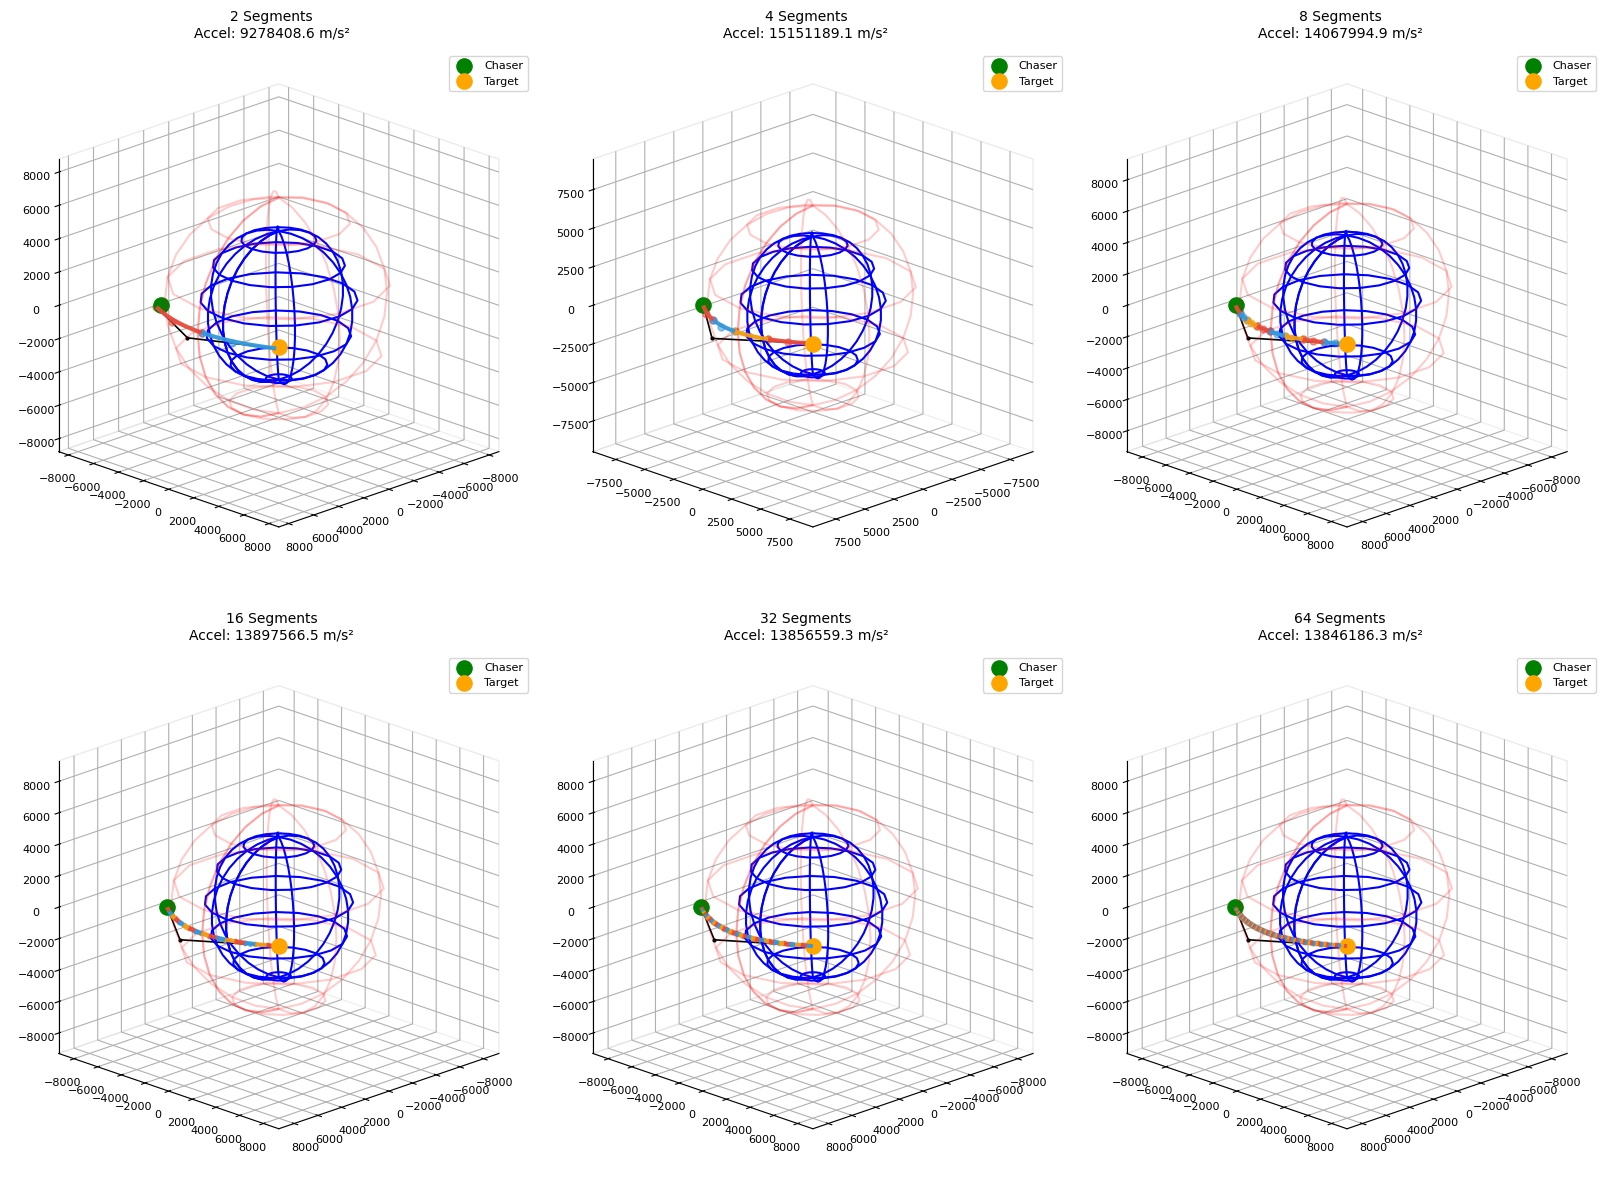

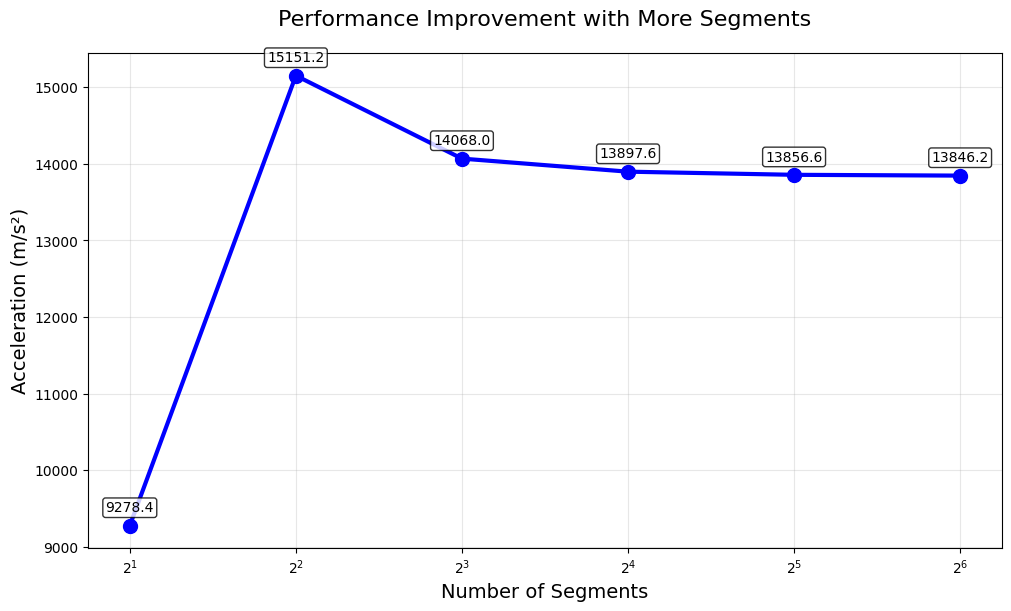

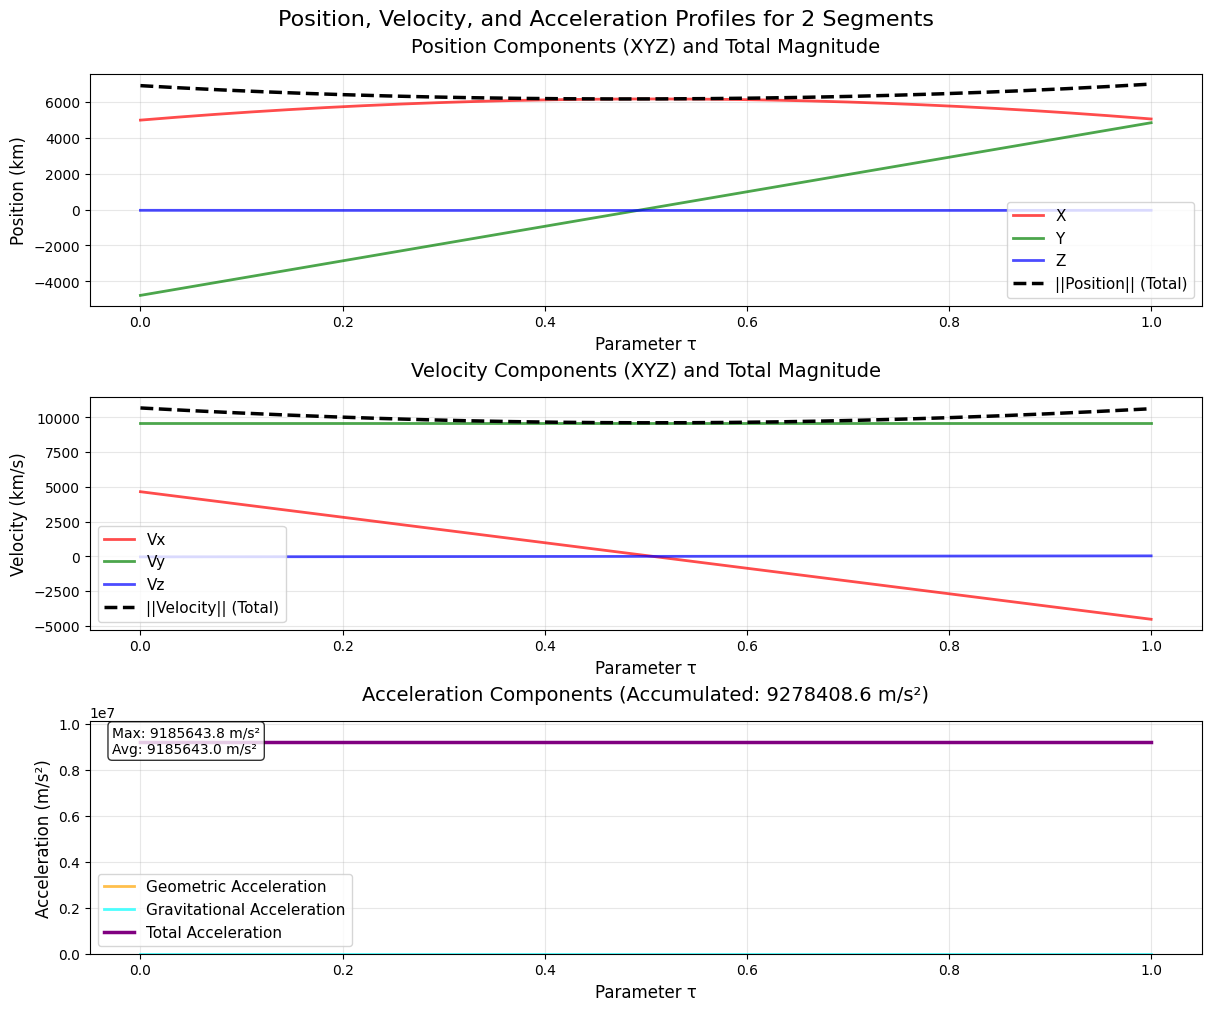

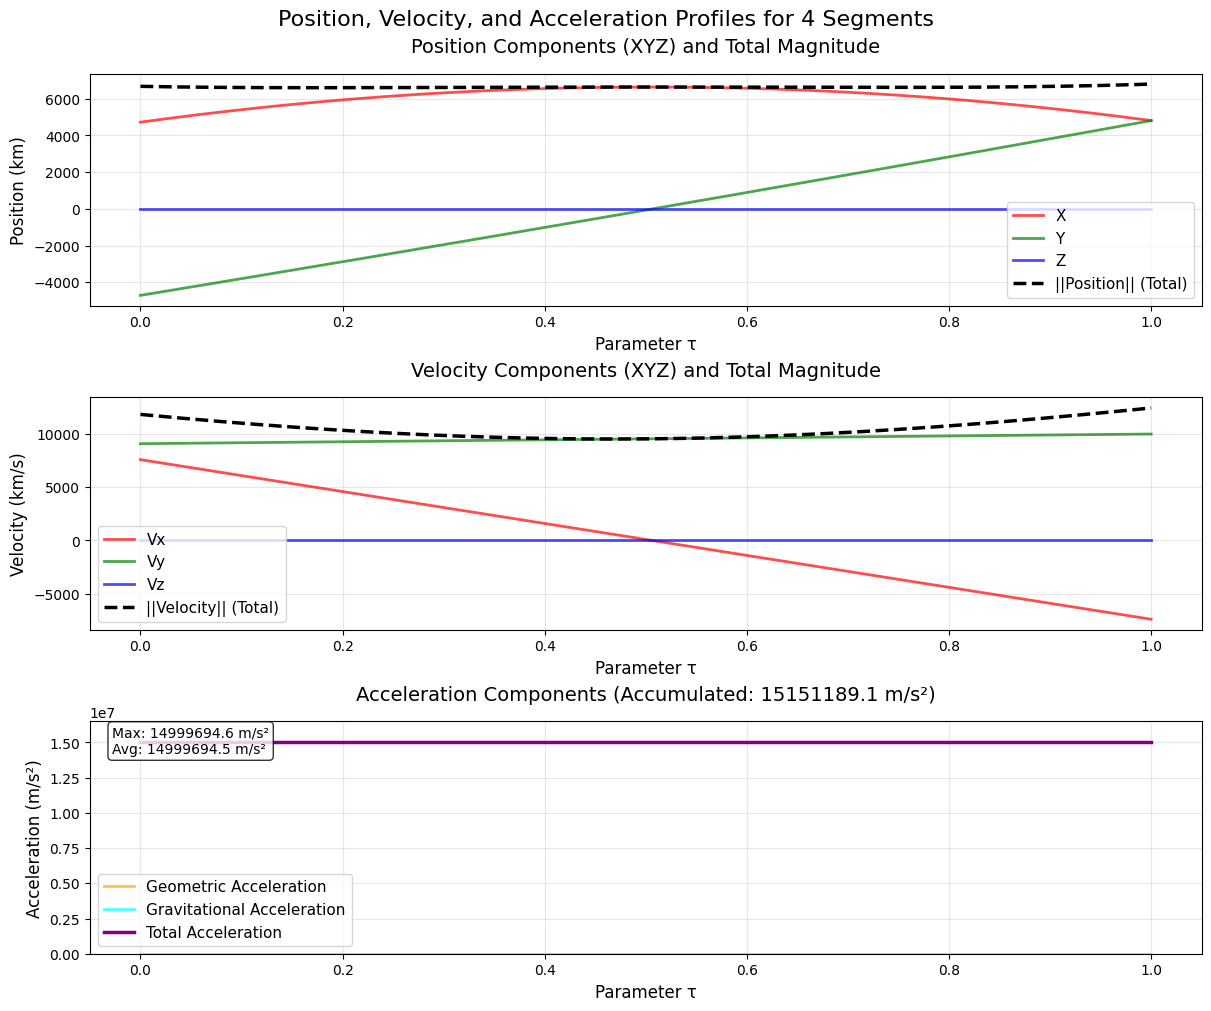

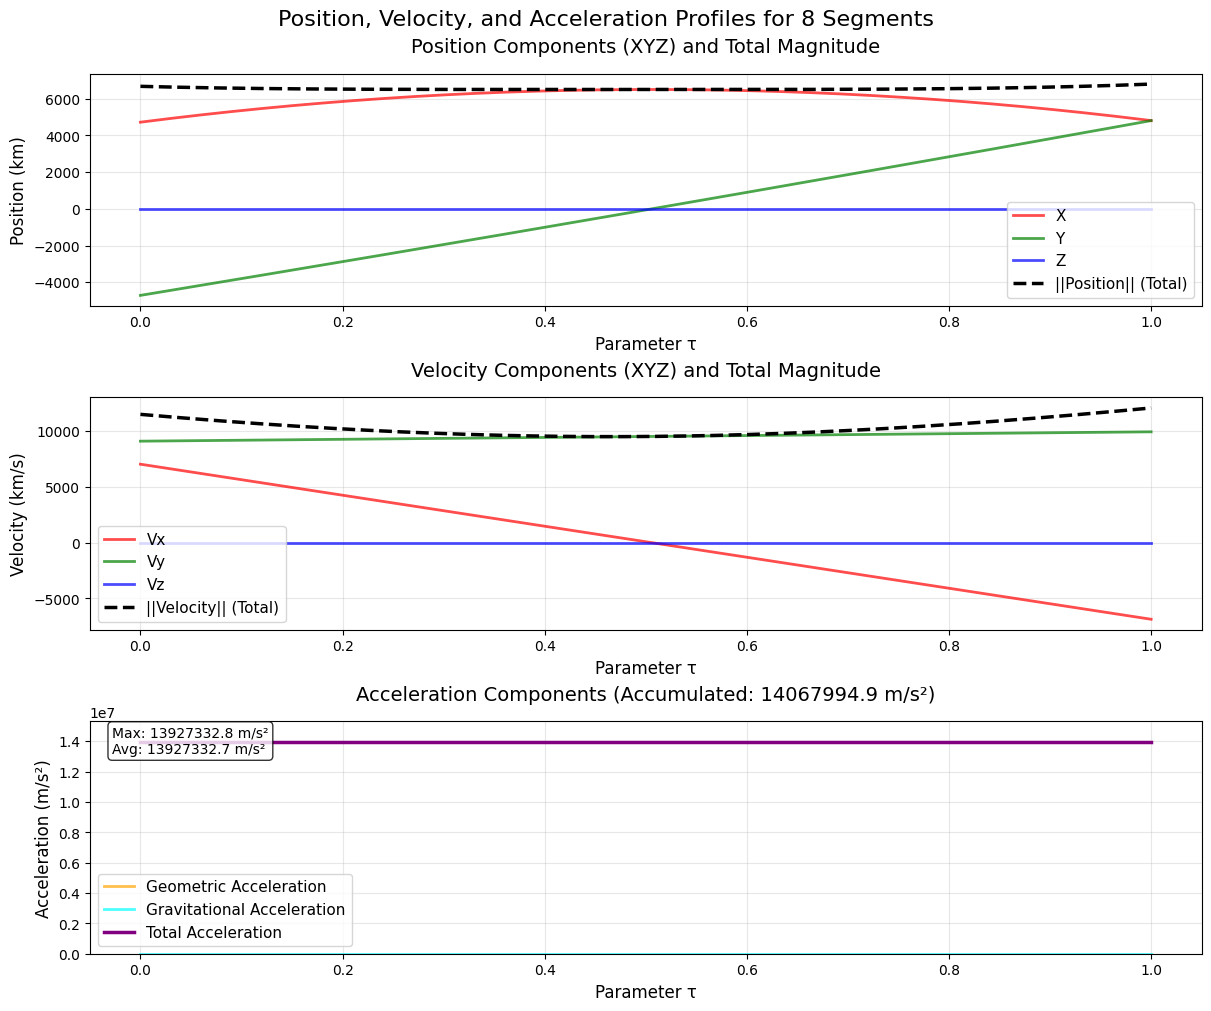

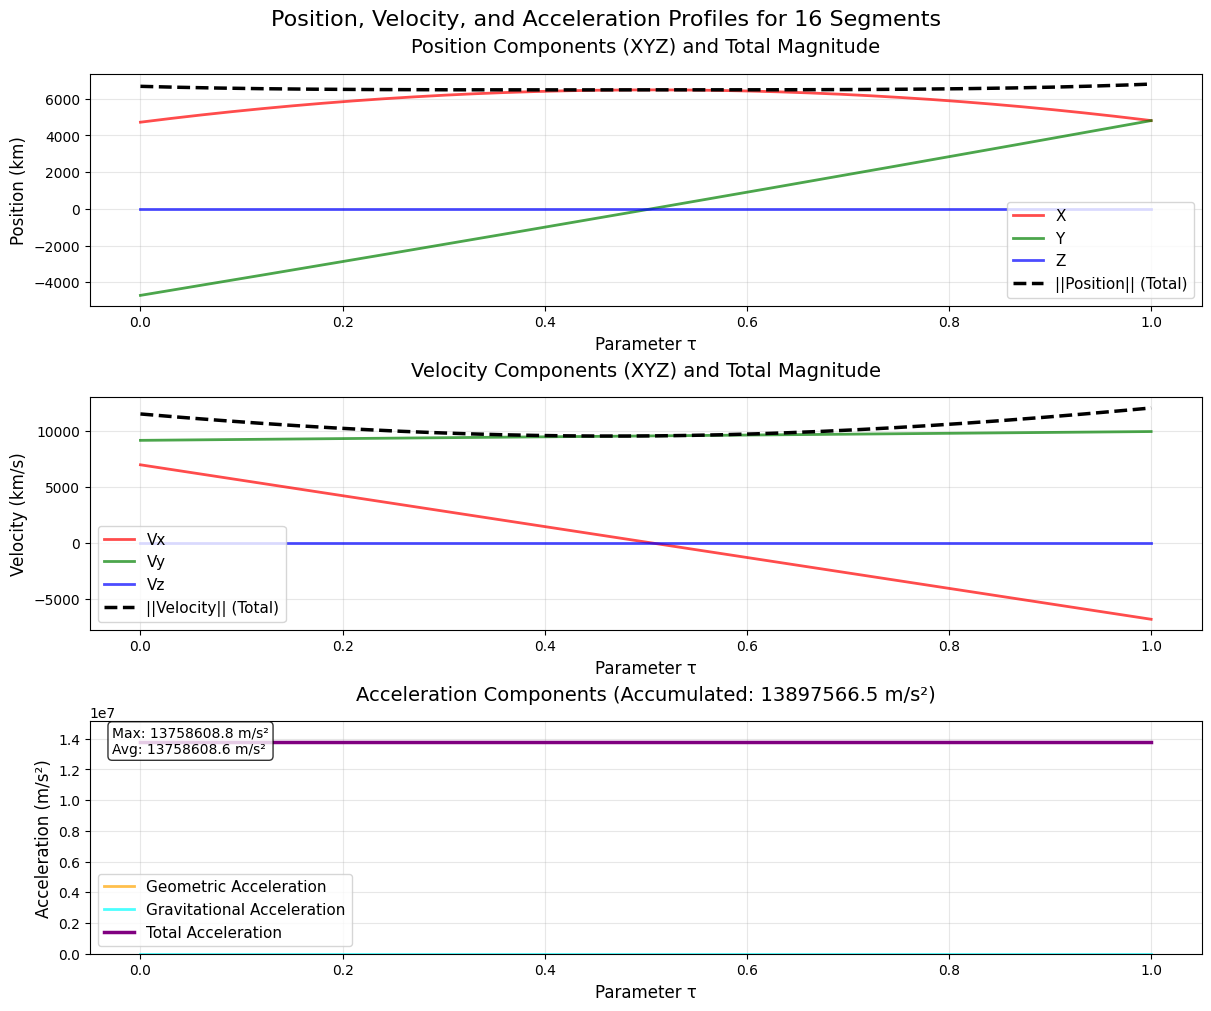

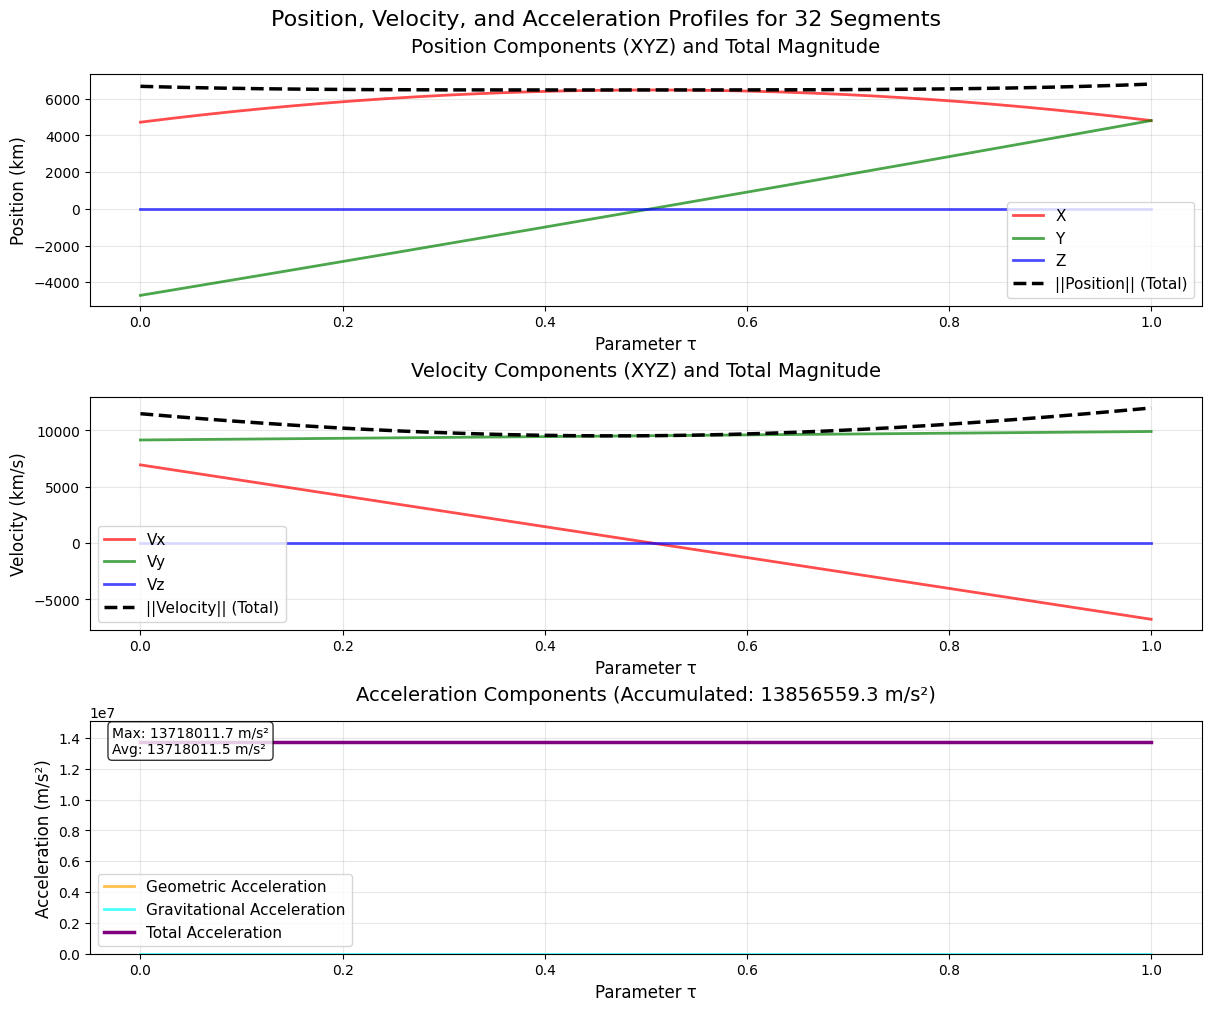

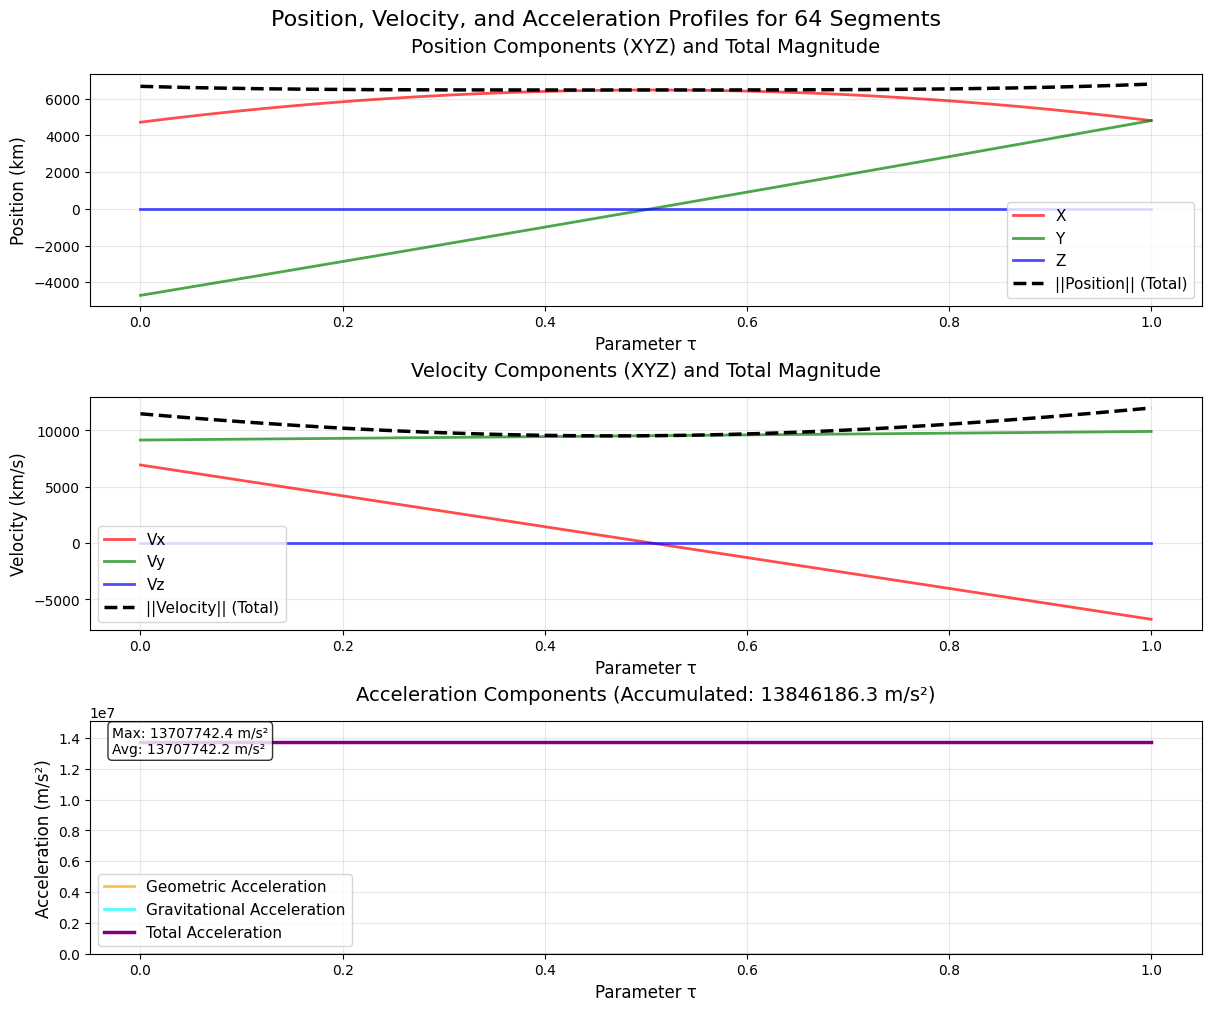


✅ N=2 (Quadratic) visualizations complete!

📈 Creating calculation time vs curve order figure...


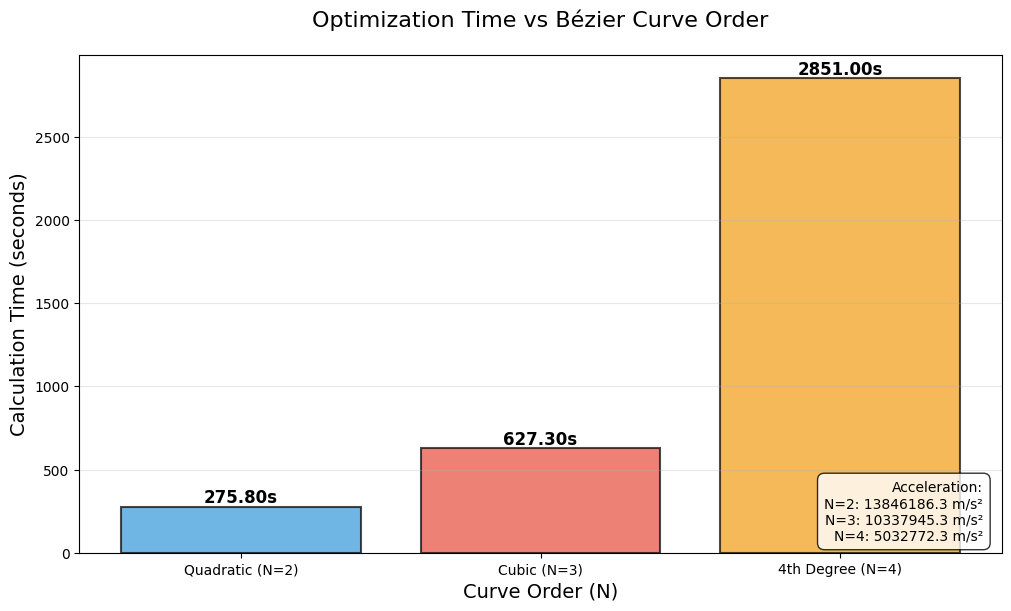


✅ Calculation time vs curve order figure complete!

Summary:
  N=2 (Quadratic): 275.80 seconds
  N=3 (Cubic):      627.30 seconds
  N=4 (4th Degree): 2851.00 seconds


In [58]:
# VISUALIZATION: N=2 (Quadratic) Results
print("\n📊 Creating visualizations for N=2 (Quadratic curve)...")
print("=" * 60)

# Create and display the 2×3 comparison figure for N=2
fig_comparison_N2 = create_trajectory_comparison_figure(P_init_N2, KOZ_RADIUS, results_N2)

# Create and display the performance figure for N=2
fig_performance_N2 = create_performance_figure(results_N2)

# Create acceleration figures for each segment count (N=2)
print("\nCreating acceleration profiles for N=2...")
accel_figures_N2 = {}
for seg_count in [2, 4, 8, 16, 32, 64]:
    fig = create_acceleration_figure(results_N2, segcount=seg_count)
    accel_figures_N2[seg_count] = fig
    print(f"✓ Created profiles for {seg_count} segments")

plt.show()

print("\n✅ N=2 (Quadratic) visualizations complete!")

# CALCULATION TIME VS CURVE ORDER ANALYSIS
print("\n" + "=" * 60)
print("📈 Creating calculation time vs curve order figure...")
print("=" * 60)

# Prepare data for time vs order figure
calculation_times = {
    2: elapsed_time_N2,
    3: elapsed_time_N3,
    4: elapsed_time_N4
}

# For optimization results, we'll use the best result (typically 64 segments)
# Extract the best result for each curve order
optimization_results = {}
for N in [2, 3, 4]:
    if N == 2:
        results = results_N2
    elif N == 3:
        results = results_N3
    else:  # N == 4
        results = results_N4
    
    # Find the result with 64 segments (or use the last one)
    P_opt, info = None, None
    for seg_count, P_opt_iter, info_iter in results:
        if seg_count == 64:
            P_opt, info = P_opt_iter, info_iter
            break
    
    # Fallback to last result
    if P_opt is None and len(results) > 0:
        P_opt, info = results[-1][1], results[-1][2]
    
    optimization_results[N] = (P_opt, info)

# Create and display the time vs order figure
fig_time_order = create_time_vs_order_figure(calculation_times, optimization_results)
plt.show()

print("\n✅ Calculation time vs curve order figure complete!")
print(f"\nSummary:")
print(f"  N=2 (Quadratic): {elapsed_time_N2:.2f} seconds")
print(f"  N=3 (Cubic):      {elapsed_time_N3:.2f} seconds")
print(f"  N=4 (4th Degree): {elapsed_time_N4:.2f} seconds")
